### Imports

In [244]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

### Grab Data

In [187]:
#Use yfinance to grab S&P500 and VIX data from 2000-2022
ticker = ['^GSPC']
start_date = '2000-01-01'
end_date = '2022-12-31'

df = yf.download(ticker, start=start_date, end=end_date)
df_vix = yf.download('^VIX', start= start_date, end = end_date)
#Let's also add vix 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### EDA

In [188]:
df_vix.rename(columns={'Close':'vix'},inplace=True)
df = pd.merge(df,df_vix['vix'],on='Date')

In [189]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,vix
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5.787000e+03,5787.000000
mean,1873.617096,1884.787935,1861.463916,1873.787740,1873.787740,3.297658e+09,20.188251
std,965.512281,970.466509,960.011824,965.542311,965.542311,1.525812e+09,8.698178
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08,9.140000
25%,1183.795044,1190.855042,1175.725037,1183.630005,1183.630005,1.974930e+09,13.960000
50%,1431.770020,1440.160034,1422.339966,1430.829956,1430.829956,3.401300e+09,18.160000
75%,2365.655029,2372.315063,2353.739990,2364.340088,2364.340088,4.158225e+09,23.950001
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,1.145623e+10,82.690002


In [190]:
#no difference in adj close vs close
print((df['Adj Close'] == df['Close']).sum(), len(df))

5787 5787


In [191]:
#check for null values, no DQ issues
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
vix          0
dtype: int64

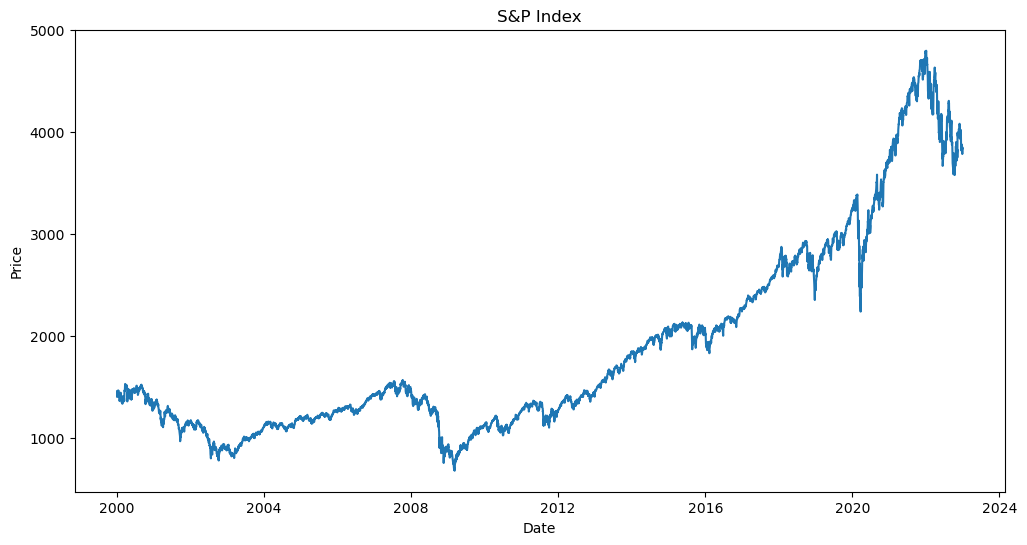

In [192]:
#Plot the Data
plt.figure(figsize=(12,6))
plt.plot(df.index,df['Close'], linestyle ='-')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P Index')
plt.show()

### Feature Engineering

In [193]:
#We want to predict the next close price. 
df['Next_Close'] = df['Close'].shift(-1)


In [194]:
#We make all features lagged by 1 in order to be able to predict tomorrow's close
#We also wouldn't have today's moving average values as we are trading before today's close
#should I add VIX? we should test model performance with this feature

#Simple Moving Averages from 3,5,7 and 20 days
for i in (3,5,7,20):
    df[f'sma_{i}'] = df['Close'].rolling(i).mean()

#Exponential Moving Averages from 9, 12 and 26 days. These are common values
for i in (9,12,26):
    df[f'ema_{i}'] = df['Close'].ewm(span=i).mean()

#Bollinger Bands, we want to see if the price is outside of the 2 standard deviation range of the 20 day moving average
df['std_dev_20'] = df['Close'].rolling(20).std()
df['bb_upper_band'] = df['sma_20'] + (df['std_dev_20'] * 2)
df['bb_lower_band'] = df['sma_20'] - (df['std_dev_20'] * 2)

#implementing macd

df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span = 9).mean()
df['macd_histogram'] = df['macd'] - df['macd_signal']


#Relative Strength Index, can show whether the stock is overbought/oversold
def calculate_rsi(df):
    close_diff = df['Close'].diff(1)
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['rsi'] = calculate_rsi(df)

#Due to creating these lagged features, we should drop rows with any null features
df.dropna(inplace=True)
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
vix               0
Next_Close        0
sma_3             0
sma_5             0
sma_7             0
sma_20            0
ema_9             0
ema_12            0
ema_26            0
std_dev_20        0
bb_upper_band     0
bb_lower_band     0
macd              0
macd_signal       0
macd_histogram    0
rsi               0
dtype: int64

Feature Analysis

(18262.0, 18627.0)

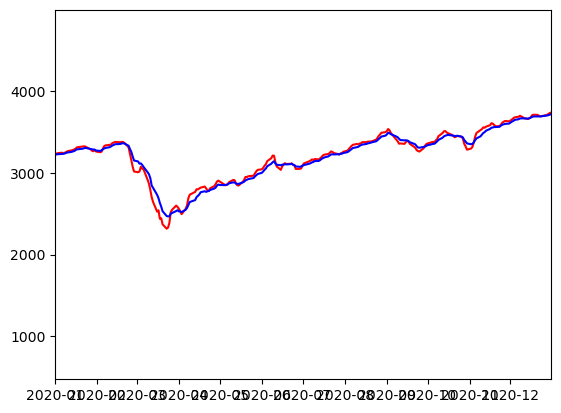

In [195]:
#SMA plot
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2020-12-31')
plt.plot(figsize = (12,6))

plt.plot(df.index,df['sma_3'], label = 'SMA 3', color = 'red')
plt.plot(df.index,df['ema_9'], label = 'EMA 9', color = 'blue')
plt.xlim(start_date,end_date)

Text(0.5, 0.98, 'MACD, Signal Line, and Price')

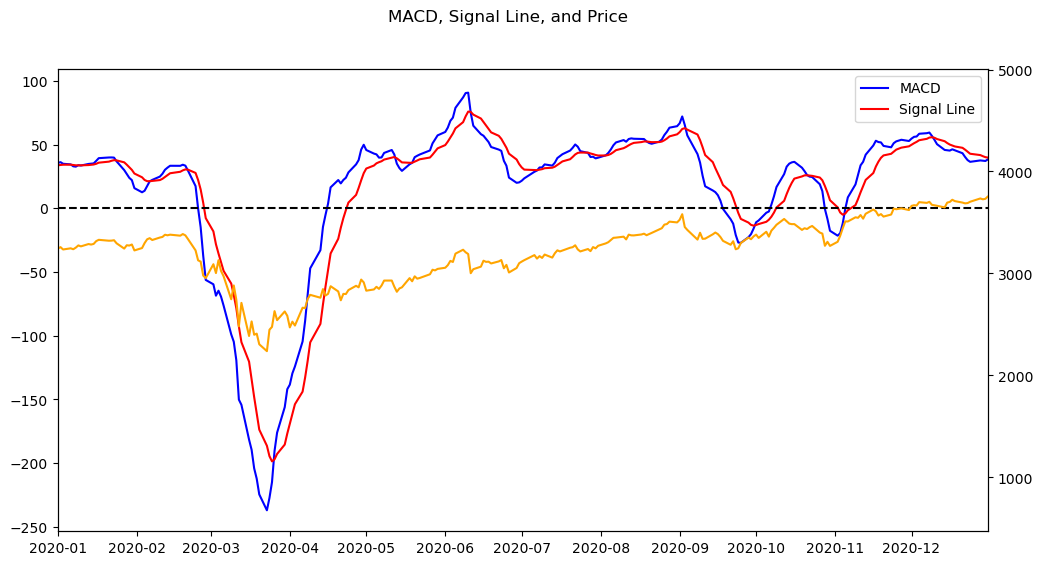

In [196]:
# MACD plot
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2020-12-31')
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df.index, df['macd'], label='MACD', color='blue')
ax1.plot(df.index, df['macd_signal'], label='Signal Line', color='red')
ax2.plot(df.index, df['Close'], label='Price', color='orange')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xlim(start_date, end_date)
ax1.legend()
fig.suptitle('MACD, Signal Line, and Price')

In [197]:
corr_matrix = df[['Volume', 'sma_3', 'sma_5','sma_7','sma_20','std_dev_20',
       'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
       'rsi','vix','bb_lower_band','bb_upper_band','Next_Close']].corr()['Next_Close']

sorted_corr = corr_matrix.abs().sort_values(ascending=False)


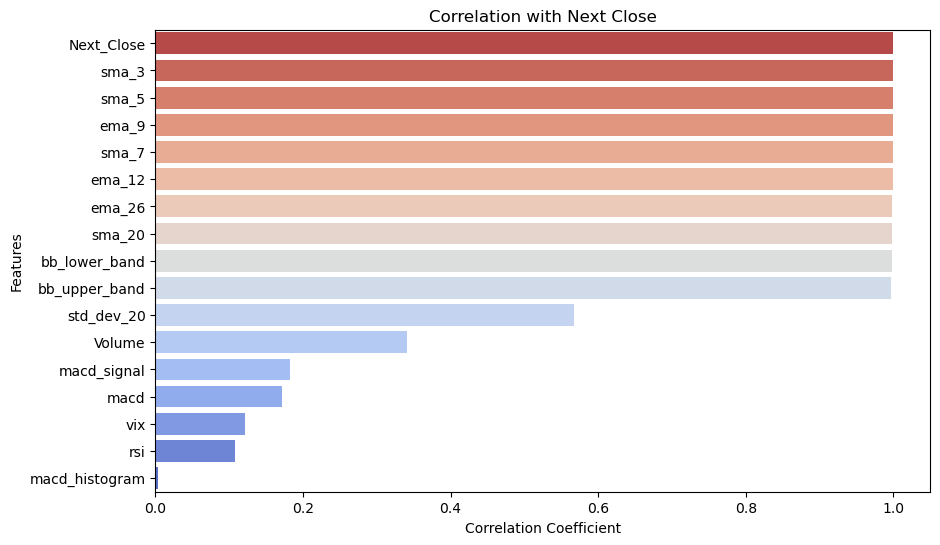

In [198]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette="coolwarm_r")
plt.title(f'Correlation with Next Close')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

### Time Series Splitting for Cross Validation

In [199]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10,test_size=1)
df = df.sort_index()

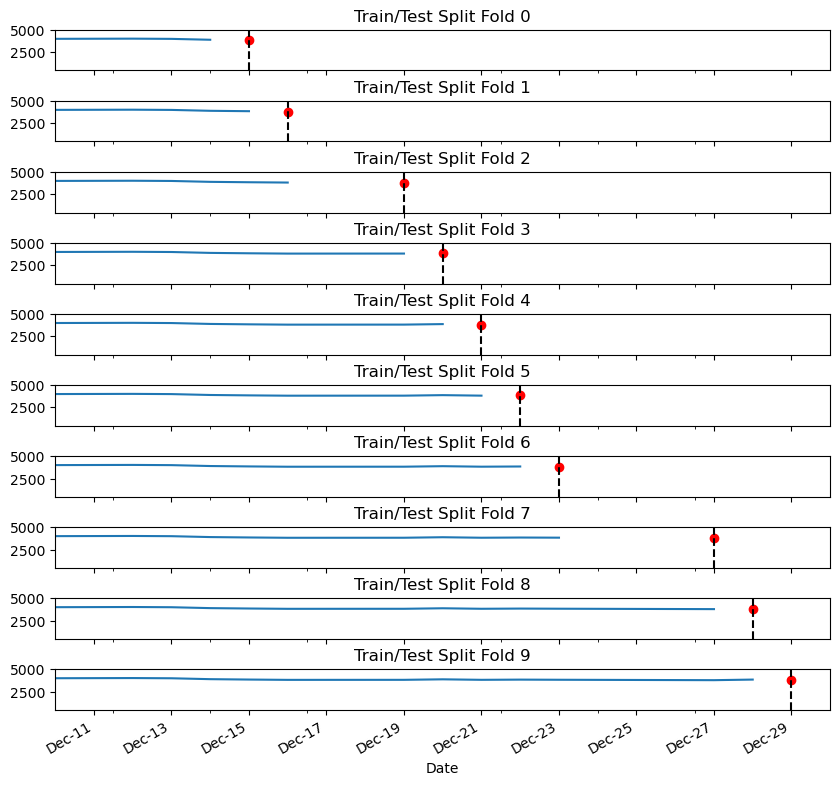

In [200]:

fig, axs = plt.subplots(10, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0.75})

fold = 0
for train_idx, val_idx in tss.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]
    train_df['Next_Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train/Test Split Fold {fold}')
    
    axs[fold].scatter(test_df.index, test_df['Next_Close'], marker='o', color='red', label='Test Set')

    axs[fold].set_xlim(pd.Timestamp('2022-12-10'), pd.Timestamp('2022-12-30'))
    axs[fold].axvline(test_df.index.min(), color='black', ls='--')
    date_format = mdates.DateFormatter('%b-%d')
    axs[fold].xaxis.set_major_formatter(date_format)

    fold += 1
plt.show()

### Linear Regression

In [250]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5,test_size=1,gap = 30)
df = df.sort_index()

In [213]:
preds = []
scores = []
actuals = []

for train_idx, val_idx in tss.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]

    features = ['sma_3', 'sma_5','sma_7','sma_20',
       'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
       'rsi','Volume','bb_lower_band','bb_upper_band','std_dev_20']
    
    target = 'Next_Close'

    X_train = train_df[features]
    y_train = train_df[target]
    y_train = np.log1p(y_train)

    X_test = test_df[features]
    y_test = test_df[target]
    y_test = np.log1p(y_test)

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    actual_dict = [{'Date': date, 'Actual': actual, "Preds": pred} for date, actual, pred in zip(test_df.index, y_test, y_pred)]
    actuals.extend(actual_dict)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)




In [214]:
#important features
coefficients = model.coef_
coefficients_df = pd.DataFrame({'Features': X_train.columns, 'Coefficients': coefficients})
sorted_coefficients = coefficients_df.sort_values(by='Coefficients', ascending=False)
print(sorted_coefficients)


          Features  Coefficients
4           ema_12  5.254157e-02
6             macd  3.339862e-02
8   macd_histogram  3.232214e-02
5           ema_26  1.914295e-02
9              rsi  1.241379e-03
7      macd_signal  1.076477e-03
0            sma_3  6.270181e-04
10          Volume -2.053473e-12
1            sma_5 -5.569051e-05
2            sma_7 -4.047414e-04
3            ema_9 -7.138945e-02


In [215]:
y_test_df = pd.DataFrame(actuals)
y_test_df['Actual'] = np.exp(y_test_df['Actual'])
y_test_df['Preds'] = np.exp(y_test_df['Preds'])
y_test_df['Error'] = abs((y_test_df['Preds'] - y_test_df['Actual']) / y_test_df['Actual']) * 100

In [216]:
#an r2 score between 0.7 and 1.0 is considered good
r2_score(y_test_df['Actual'],y_test_df['Preds'])

-227.48134153276757

In [218]:
mean_absolute_error(y_test_df['Actual'],y_test_df['Preds'])

358.3263999934711

In [219]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0894
Fold scores:[0.08009868570484713, 0.1029988013073897, 0.10677313889348206, 0.07843424300250312, 0.07878301827452994]


### Random Forest Regressor

In [251]:
preds = []
scores = []
actuals = []

for train_idx, val_idx in tss.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]

    features = ['sma_3', 'sma_5','sma_7','sma_20',
       'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
       'rsi','Volume','bb_lower_band','bb_upper_band','std_dev_20']
    
    target = 'Next_Close'

    X_train = train_df[features]
    y_train = train_df[target]

    X_test = test_df[features]
    y_test = test_df[target]

    model = RandomForestRegressor(n_estimators=2000, max_depth=3, n_jobs=16,)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    actual_dict = [{'Date': date, 'Actual': actual, "Preds": pred} for date, actual, pred in zip(test_df.index, y_test, y_pred)]
    actuals.extend(actual_dict)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


In [252]:
y_test_df = pd.DataFrame(actuals)
y_test_df['Error'] = abs((y_test_df['Preds'] - y_test_df['Actual']) / y_test_df['Actual']) * 100

In [253]:
#an r2 score between 0.7 and 1.0 is considered good
r2_score(y_test_df['Actual'],y_test_df['Preds'])

-0.038010438829274795

In [254]:
#On average my model may be off by $11 from the actuals
mean_absolute_error(y_test_df['Actual'],y_test_df['Preds'])

20.622870860774583

### XGBOOST Regressor

In [291]:
preds = []
scores = []
actuals = []

for train_idx, val_idx in tss.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]

    features = ['sma_3', 'sma_5','sma_7','sma_20',
       'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
       'rsi','Volume','bb_lower_band','bb_upper_band','std_dev_20']
    
    target = 'Next_Close'

    X_train = train_df[features]
    y_train = train_df[target]

    X_test = test_df[features]
    y_test = test_df[target]

    model = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.1)

    model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    actual_dict = [{'Date': date, 'Actual': actual, "Preds": pred} for date, actual, pred in zip(test_df.index, y_test, y_pred)]
    actuals.extend(actual_dict)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:862.46843	validation_1-rmse:1787.24096


[100]	validation_0-rmse:25.12536	validation_1-rmse:24.82227
[187]	validation_0-rmse:22.81212	validation_1-rmse:35.38086
[0]	validation_0-rmse:862.75038	validation_1-rmse:1771.25782
[100]	validation_0-rmse:25.15913	validation_1-rmse:10.40942
[179]	validation_0-rmse:23.04618	validation_1-rmse:25.57910
[0]	validation_0-rmse:863.05100	validation_1-rmse:1724.67845
[79]	validation_0-rmse:26.21349	validation_1-rmse:58.00146
[0]	validation_0-rmse:863.33350	validation_1-rmse:1790.34620
[100]	validation_0-rmse:25.23089	validation_1-rmse:47.06494
[200]	validation_0-rmse:22.78422	validation_1-rmse:27.08032
[244]	validation_0-rmse:21.91146	validation_1-rmse:32.02808
[0]	validation_0-rmse:863.62742	validation_1-rmse:1779.93897
[100]	validation_0-rmse:25.29030	validation_1-rmse:29.75781
[200]	validation_0-rmse:22.71969	validation_1-rmse:15.45361
[279]	validation_0-rmse:21.30518	validation_1-rmse:7.93286


In [292]:
y_test_df = pd.DataFrame(actuals)
y_test_df['Error'] = abs((y_test_df['Preds'] - y_test_df['Actual']) / y_test_df['Actual']) * 100

In [293]:
#an r2 score between 0.7 and 1.0 is considered good
r2_score(y_test_df['Actual'],y_test_df['Preds'])

0.5792354450896364

In [294]:
#On average my model may be off by $11 from the actuals
mean_absolute_error(y_test_df['Actual'],y_test_df['Preds'])

11.496240234375

### Parameter Tuning

In [241]:
scores = []
preds = []
actuals = []
df_scores = pd.DataFrame(columns = ['max_depth', 'learning_rate','min_child_weight', 'score'])

for i in (3,4,5):
    for j in (0.1,0.01,0.2):
        for k in (1, 5, 15):

                for train_idx, val_idx in tss.split(df):
                    train_df = df.iloc[train_idx]
                    test_df = df.iloc[val_idx]

                    score = []
                    
                    features = ['sma_3', 'sma_5','sma_7','sma_20',
                    'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
                    'rsi','Volume','bb_lower_band','bb_upper_band','std_dev_20']
                                    
                    target = 'Next_Close'

                    X_train = train_df[features]
                    y_train = train_df[target]

                    X_test = test_df[features]
                    y_test = test_df[target]

                    model = xgb.XGBRegressor(booster='gbtree',    
                                        n_estimators=1000,
                                        early_stopping_rounds=50,
                                        objective='reg:squarederror',
                                        max_depth=i,
                                        learning_rate=j,
                                        min_child_weight = k)

                    model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=0)

                    y_pred = model.predict(X_test)
                    preds.append(y_pred)
                    # actual_dict = [{'Date': date, 'Actual': actual, "Preds": pred} for date, actual, pred in zip(test_df.index, y_test, y_pred)]
                    # actuals.extend(actual_dict)
                    score = np.sqrt(mean_squared_error(y_test, y_pred))
                    scores.append(score)
                    data = {
                        'max_depth': i,
                        'learning_rate': j,
                        'min_child_weight': k,
                        'score': np.mean(scores)
                    }

                    df_scores = df_scores.append(data, ignore_index=True)

                    print(i, ", ", j, ": ",np.mean(scores))


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  21.798828125
3 ,  0.1 :  14.1072998046875
3 ,  0.1 :  9.888427734375


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  13.9613037109375


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  11.496240234375
3 ,  0.1 :  11.708658854166666


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  10.092389787946429
3 ,  0.1 :  9.012176513671875
3 ,  0.1 :  12.55295138888889


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  11.3552001953125
3 ,  0.1 :  11.429354580965908


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  10.495096842447916
3 ,  0.1 :  9.79937274639423


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  10.349051339285714


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.1 :  9.674593098958333


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  11.05078125


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  10.769416360294118


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  10.181749131944445


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  12.423108552631579


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  13.42197265625


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  14.292945498511905


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  13.917990944602273


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  13.321182914402174


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  14.963907877604166


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  15.670810546875


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  15.982703575721153


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  15.653889973958334


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  15.101658412388392


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  16.405433391702587


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.01 :  16.6260498046875
3 ,  0.2 :  16.527233492943548
3 ,  0.2 :  16.056068420410156


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  15.576933889678031
3 ,  0.2 :  15.124418370863971


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  14.701297433035714
3 ,  0.2 :  14.516432020399305
3 ,  0.2 :  14.163283889358109


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  13.79700349506579
3 ,  0.2 :  13.45668694911859


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  13.130059814453125
3 ,  0.2 :  12.822884908536585


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  12.568731398809524
3 ,  0.2 :  12.282124364098838


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


3 ,  0.2 :  12.004810680042613
3 ,  0.2 :  11.927311197916667


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  11.96008831521739
4 ,  0.1 :  12.045571185172872


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  11.803914388020834
4 ,  0.1 :  12.341577646683673


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  12.20458984375
4 ,  0.1 :  12.405895756740197


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  12.185373159555288
4 ,  0.1 :  11.95950029481132


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  12.066984953703704


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  11.849866832386363
4 ,  0.1 :  11.645224434988839


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  11.445757949561404
4 ,  0.1 :  11.2784423828125


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.1 :  11.336090605137711
4 ,  0.1 :  11.154532877604167


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  11.472516169313524


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  11.473853326612904


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  11.293243892609127


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.047920227050781


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.202982271634616


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.268236564867424


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.171124358675373


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  11.994564280790442


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.426863960597826


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.672370256696428


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.697643871038732


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.645677354600695


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  12.473328472816782


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  13.054506044130068


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.01 :  13.106656901041667
4 ,  0.2 :  12.969704075863486


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.8013868455763
4 ,  0.2 :  12.676485501802885
4 ,  0.2 :  12.999462272547468


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.955020141601562
4 ,  0.2 :  13.010422694830247
4 ,  0.2 :  12.869322241806403


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.752620834902109
4 ,  0.2 :  12.748648507254464


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.858191636029412
4 ,  0.2 :  12.719419967296512


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.59954763829023
4 ,  0.2 :  12.492345636541193
4 ,  0.2 :  12.872950864641854


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


4 ,  0.2 :  12.75381130642361
5 ,  0.1 :  12.98630129635989


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  12.946872877038043
5 ,  0.1 :  12.824226625504032


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.17963555518617


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.087225020559211


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.34716796875
5 ,  0.1 :  13.521668109697165


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.411496532206632


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.731003886521465


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.59616943359375


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.461556311881187
5 ,  0.1 :  13.417379940257353


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.316612465867719


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.65575937124399


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.1 :  13.525909133184523


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  13.749981574292454


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  13.868914737879672


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  13.741868760850695


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.179633744266056


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.276915394176136


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.515787760416666


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.615587506975446


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.48727011891593


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  14.899069267406798


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.104959239130435


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.220250622979526


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.131017962072649


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.003885560116526


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.5728872603729


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.01 :  15.633750406901042


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.846459759168388
5 ,  0.2 :  15.836119604892419


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.723468067200203


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.892538747479838


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.9272578125
5 ,  0.2 :  15.992321196056547


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.908533772145669
5 ,  0.2 :  15.81344985961914


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.954446008963178
5 ,  0.2 :  16.188837139423075


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  16.161490636927482
5 ,  0.2 :  16.03988924893466


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


5 ,  0.2 :  15.920020999765038
5 ,  0.2 :  16.154218531366606
5 ,  0.2 :  16.03568431712963


C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)
C:\Users\faroq\AppData\Local\Temp\ipykernel_2464\232416344.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(data, ignore_index=True)


In [242]:
#Best score is max_depth = 3, learning_rate = 0.1, min_child_weight = 5
df_scores.sort_values(by='score').head(10)


,max_depth,learning_rate,min_child_weight,score
7,3.0,0.10,5.0,9.012177
14,3.0,0.10,15.0,9.674593
12,3.0,0.10,15.0,9.799373
2,3.0,0.10,1.0,9.888428
6,3.0,0.10,5.0,10.092390
17,3.0,0.01,1.0,10.181749
13,3.0,0.10,15.0,10.349051
11,3.0,0.10,15.0,10.495097
16,3.0,0.01,1.0,10.769416
15,3.0,0.01,1.0,11.050781


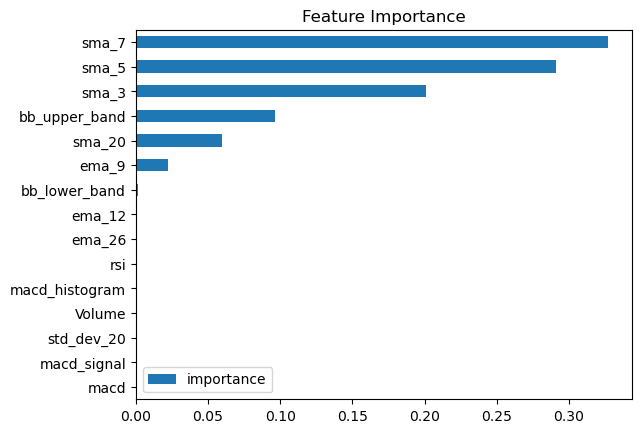

In [297]:
#important features
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Final Eval

In [304]:
train_df = df.loc[df.index <= '01-01-2020']
test_df = df.loc[df.index > '01-01-2020']
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=len(test_df),test_size=1)

In [305]:
#final model - predicting next close
preds = []
scores = []
actuals = []

for train_idx, val_idx in tss.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]


    features = ['sma_3', 'sma_5','sma_7','sma_20',
    'ema_9', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_histogram',
    'rsi','Volume','bb_lower_band','bb_upper_band','std_dev_20']

    # features = ['sma_3', 'sma_5','sma_7','sma_20',
    # 'ema_9','Volume','bb_lower_band','bb_upper_band']




    target = 'Next_Close'

    X_train = train_df[features]
    y_train = train_df[target]

    X_test = test_df[features]
    y_test = test_df[target]

    model = xgb.XGBRegressor(booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.1,
                           min_child_weight = 5,
                           n_jobs = -1)

    model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1000)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    actual_dict = [{'Date': date, 'Actual': actual, "Preds": pred} for date, actual, pred in zip(test_df.index, y_test, y_pred)]
    actuals.extend(actual_dict)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)



[0]	validation_0-rmse:529.96597	validation_1-rmse:1525.91104
[118]	validation_0-rmse:18.44132	validation_1-rmse:58.76709
[0]	validation_0-rmse:530.33525	validation_1-rmse:1536.01701
[117]	validation_0-rmse:18.49792	validation_1-rmse:64.46216
[0]	validation_0-rmse:530.68828	validation_1-rmse:1527.33207
[177]	validation_0-rmse:17.81689	validation_1-rmse:46.20605
[0]	validation_0-rmse:531.08163	validation_1-rmse:1542.76951
[168]	validation_0-rmse:17.74008	validation_1-rmse:52.43726
[0]	validation_0-rmse:531.45933	validation_1-rmse:1563.97434
[269]	validation_0-rmse:16.83082	validation_1-rmse:67.55542
[0]	validation_0-rmse:531.84767	validation_1-rmse:1553.25899
[218]	validation_0-rmse:17.40458	validation_1-rmse:38.78516
[0]	validation_0-rmse:532.22996	validation_1-rmse:1575.57839
[153]	validation_0-rmse:17.87302	validation_1-rmse:63.56665
[0]	validation_0-rmse:532.62395	validation_1-rmse:1571.06811
[373]	validation_0-rmse:16.09945	validation_1-rmse:36.88086
[0]	validation_0-rmse:533.01019	

In [306]:
y_test_df = pd.DataFrame(actuals)
y_test_df['Error'] = abs((y_test_df['Preds'] - y_test_df['Actual']) / y_test_df['Actual']) * 100

In [307]:
#r2 Score
r2_score(y_test_df['Actual'],y_test_df['Preds'])

0.9921409516684263

In [308]:
#On average my model may be off by ~$30 from the actuals
mean_absolute_error(y_test_df['Actual'],y_test_df['Preds'])

32.27399433464404

In [309]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 32.2740
Fold scores:[58.458251953125, 57.20263671875, 45.12158203125, 51.534423828125, 66.60009765625, 38.464599609375, 62.602294921875, 36.78857421875, 36.571044921875, 65.08935546875, 70.749267578125, 57.8447265625, 46.2353515625, 45.572021484375, 0.01318359375, 0.623779296875, 0.945068359375, 0.37744140625, 0.093994140625, 0.11572265625, 0.442626953125, 16.361328125, 52.695068359375, 45.728759765625, 31.455078125, 63.302978515625, 58.84912109375, 80.762451171875, 71.924072265625, 61.173828125, 39.987548828125, 63.13525390625, 47.602783203125, 0.023193359375, 3.5302734375, 6.106201171875, 3.5068359375, 1.294677734375, 3.447021484375, 114.24609375, 3.615478515625, 132.28369140625, 0.37353515625, 0.21826171875, 13.512939453125, 0.61865234375, 0.295654296875, 0.05224609375, 52.0341796875, 10.28662109375, 18.14013671875, 2.091796875, 0.3515625, 4.835205078125, 6.990966796875, 180.197265625, 126.7861328125, 208.8740234375, 43.49951171875, 71.629150390625, 0.013671875, 0

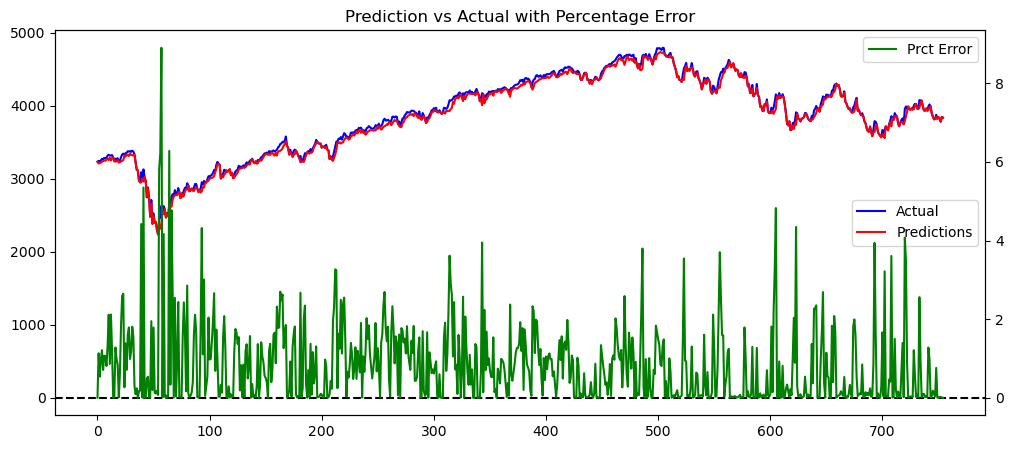

In [234]:
#pred vs actual regressor

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(y_test_df.index, y_test_df['Actual'], label='Actual', color='blue')
ax1.plot(y_test_df.index, y_test_df['Preds'], label='Predictions', color='red')
ax1.axhline(0, color='black', linestyle='--')
ax1.legend(loc ='right')

ax2 = ax1.twinx()
ax2.plot(y_test_df.index, y_test_df['Error'], label='Prct Error', color='green')
ax2.legend(loc='upper right')


plt.title('Prediction vs Actual with Percentage Error')

plt.show()

